# 3. Mã hóa dữ liệu (Data Encoding)

Trong notebook này, chúng ta sẽ thực hiện các bước mã hóa dữ liệu để chuẩn bị cho việc xây dựng mô hình phân loại. Đặc biệt, chúng ta sẽ tập trung vào việc vector hóa dữ liệu văn bản và mã hóa các biến danh mục.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from collections import Counter
from ast import literal_eval

# Thư viện NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tải tài nguyên tiếng Anh từ NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Thiết lập để hiển thị biểu đồ đẹp hơn
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Để hiển thị Tiếng Việt đúng
plt.rcParams['font.family'] = 'DejaVu Sans'

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../clean_data', exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
# Đọc dữ liệu đã làm sạch
df = pd.read_csv('../clean_data/vnexpress_clean_data.csv', encoding='utf-8')

# Chuyển đổi chuỗi tags_list thành danh sách thực sự
df['tags_list'] = df['tags_list'].apply(lambda x: literal_eval(x) if pd.notna(x) else [])

print(f"Số lượng bản ghi: {len(df)}")
print(f"Số lượng cột: {len(df.columns)}")

Số lượng bản ghi: 1182
Số lượng cột: 23


## 3.1. Chuẩn bị dữ liệu văn bản

### 3.1.1. Tạo danh sách stopwords tiếng Việt

Đối với tiếng Việt, chúng ta cần tạo một danh sách stopwords riêng vì NLTK không hỗ trợ sẵn.

In [6]:
# đọc vietnamese-stopwords-dash.txt vào biến viẹtnamese_stopwords
with open('../vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()
# Đọc dữ liệu đã làm sạch
print(f"Số lượng stopwords: {len(vietnamese_stopwords)}")
print(vietnamese_stopwords[:10])

Số lượng stopwords: 1942
['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy']


In [7]:
# # Tạo danh sách stopwords tiếng Việt
# vietnamese_stopwords = [
#     'và', 'là', 'của', 'có', 'trong', 'cho', 'được', 'với', 'các', 'để', 'này', 'những',
#     'không', 'từ', 'một', 'đó', 'khi', 'người', 'vào', 'theo', 'phải', 'như', 'cũng', 'về',
#     'đã', 'sẽ', 'còn', 'bị', 'ở', 'lại', 'nên', 'tại', 'ra', 'thì', 'đến', 'trên', 'nếu',
#     'nhưng', 'đây', 'vì', 'sau', 'mà', 'làm', 'mới', 'qua', 'năm', 'nhiều', 'hay',
#     'lên', 'cùng', 'rồi', 'tới', 'vẫn', 'thể', 'nói', 'nhất', 'chỉ', 'nữa', 'rất', 'ở',
#     'trước', 'dù', 'lúc', 'rằng', 'bởi', 'luôn', 'bởi vì', 'thường', 'thêm', 'liên', 'cứ',
#     'để', 'đang', 'giờ', 'bao', 'mình', 'càng', 'vậy', 'gì', 'đều', 'thì', 'làm', 'đủ'
# ]

# Thêm stopwords tiếng Anh
# english_stopwords = set(stopwords.words('english'))
# all_stopwords = vietnamese_stopwords + list(english_stopwords)
all_stopwords = list(set(vietnamese_stopwords))

print(f"Tổng số stopwords: {len(all_stopwords)}")

Tổng số stopwords: 1942


### 3.1.2. Tiền xử lý văn bản

Chúng ta sẽ thực hiện các bước tiền xử lý văn bản bổ sung:
1. Chuyển đổi sang chữ thường
2. Loại bỏ stopwords
3. Loại bỏ dấu câu và số

Tiêu đề gốc: Elon Musk ra chatbot AI thông minh nhất Trái Đất

Tiêu đề sau khi xử lý: elon musk chatbot thông_minh trái_đất

Độ dài tiêu đề gốc vs xử lý: 48 vs 37


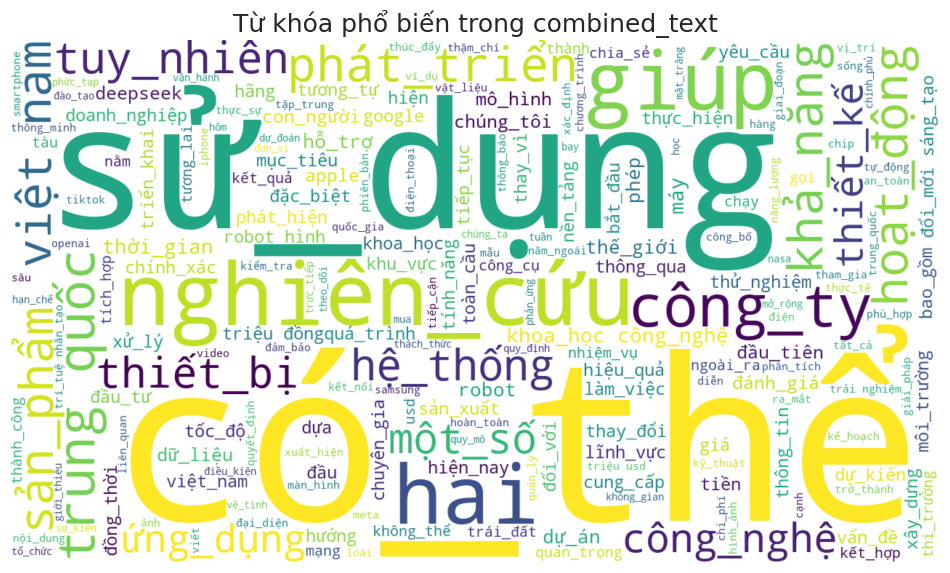

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
from wordcloud import WordCloud


def preprocess_text(text):
    if pd.isna(text) or text == '':
        return ''
    
    # Chuyển sang chữ thường
    text = text.lower()
    
    # Tokenize bằng PyVi
    tokens = ViTokenizer.tokenize(text).split()
    
    # Loại bỏ stopwords và giữ lại từ có độ dài > 2
    tokens = [word for word in tokens if word not in all_stopwords and len(word) > 2]
    
    # Gộp lại thành văn bản
    return ' '.join(tokens)

# Áp dụng tiền xử lý cho các cột văn bản
df['title_processed'] = df['title'].apply(preprocess_text)
df['description_processed'] = df['description'].apply(preprocess_text)
df['content_processed'] = df['content'].apply(preprocess_text)

# Tạo cột văn bản kết hợp (tiêu đề + mô tả + nội dung)
df['combined_text'] = df['title_processed'] + ' ' + df['description_processed'] + ' ' + df['content_processed']

# Hiển thị một ví dụ
sample_idx = 0
print("Tiêu đề gốc:", df.loc[sample_idx, 'title'])
print("\nTiêu đề sau khi xử lý:", df.loc[sample_idx, 'title_processed'])
print("\nĐộ dài tiêu đề gốc vs xử lý:", len(df.loc[sample_idx, 'title']), "vs", len(df.loc[sample_idx, 'title_processed']))

# Tạo WordCloud từ văn bản đã xử lý
all_tags = ' '.join(df['combined_text'])
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1280, height=720, background_color='white', max_words=200, contour_width=3).generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Từ khóa phổ biến trong combined_text', fontsize=18)
plt.show()


## 3.2. Vector hóa dữ liệu văn bản

### 3.2.1. Sử dụng TF-IDF Vectorizer

TF-IDF (Term Frequency-Inverse Document Frequency) là một phương pháp vector hóa văn bản phổ biến, giúp đánh giá tầm quan trọng của một từ trong văn bản dựa trên tần suất xuất hiện và sự phổ biến của từ đó.

In [29]:
# Khởi tạo TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Giới hạn số lượng đặc trưng
    min_df=5,          # Bỏ qua các từ xuất hiện trong ít hơn 5 văn bản
    max_df=0.8         # Bỏ qua các từ xuất hiện trong hơn 80% văn bản
)

# Áp dụng vectorizer cho văn bản kết hợp
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

# Lấy danh sách các đặc trưng (từ)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Số lượng đặc trưng: {len(feature_names)}")
print(f"Kích thước ma trận TF-IDF: {tfidf_matrix.shape}")
print(f"Mật độ ma trận: {tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])*100:.4f}%")

Số lượng đặc trưng: 4594
Kích thước ma trận TF-IDF: (1182, 4594)
Mật độ ma trận: 2.9805%


### 3.2.2. Top từ khóa quan trọng theo TF-IDF

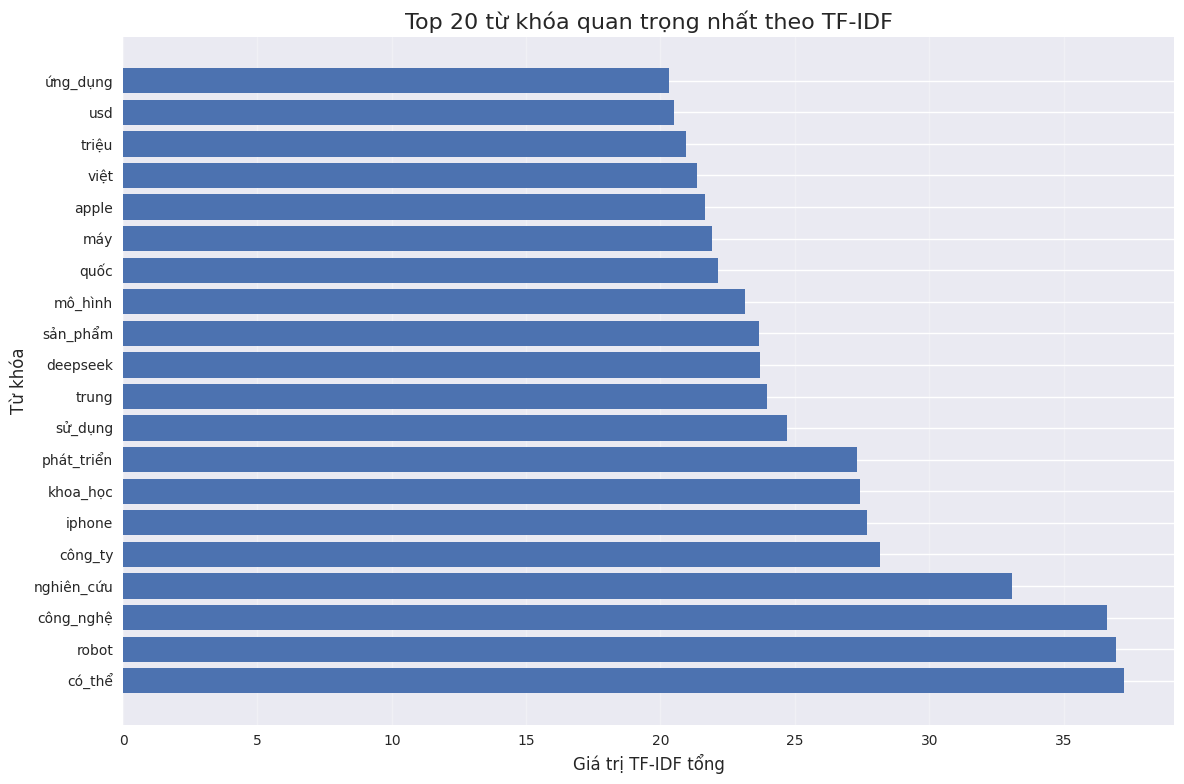

In [30]:
def get_top_tfidf_words(tfidf_matrix, feature_names, top_n=20):
    # Tính tổng giá trị TF-IDF của mỗi từ trên toàn bộ văn bản
    sums = tfidf_matrix.sum(axis=0)
    
    # Chuyển đổi thành mảng
    sums_array = np.asarray(sums).flatten()
    
    # Lấy top n từ có giá trị cao nhất
    top_indices = sums_array.argsort()[-top_n:][::-1]
    top_words = [(feature_names[i], sums_array[i]) for i in top_indices]
    
    return top_words

# Lấy top từ khóa quan trọng
top_words = get_top_tfidf_words(tfidf_matrix, feature_names, top_n=20)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
words, values = zip(*top_words)
plt.barh(words, values)
plt.title('Top 20 từ khóa quan trọng nhất theo TF-IDF', fontsize=16)
plt.xlabel('Giá trị TF-IDF tổng', fontsize=12)
plt.ylabel('Từ khóa', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2.3. So sánh từ khóa giữa hai nhóm bài viết

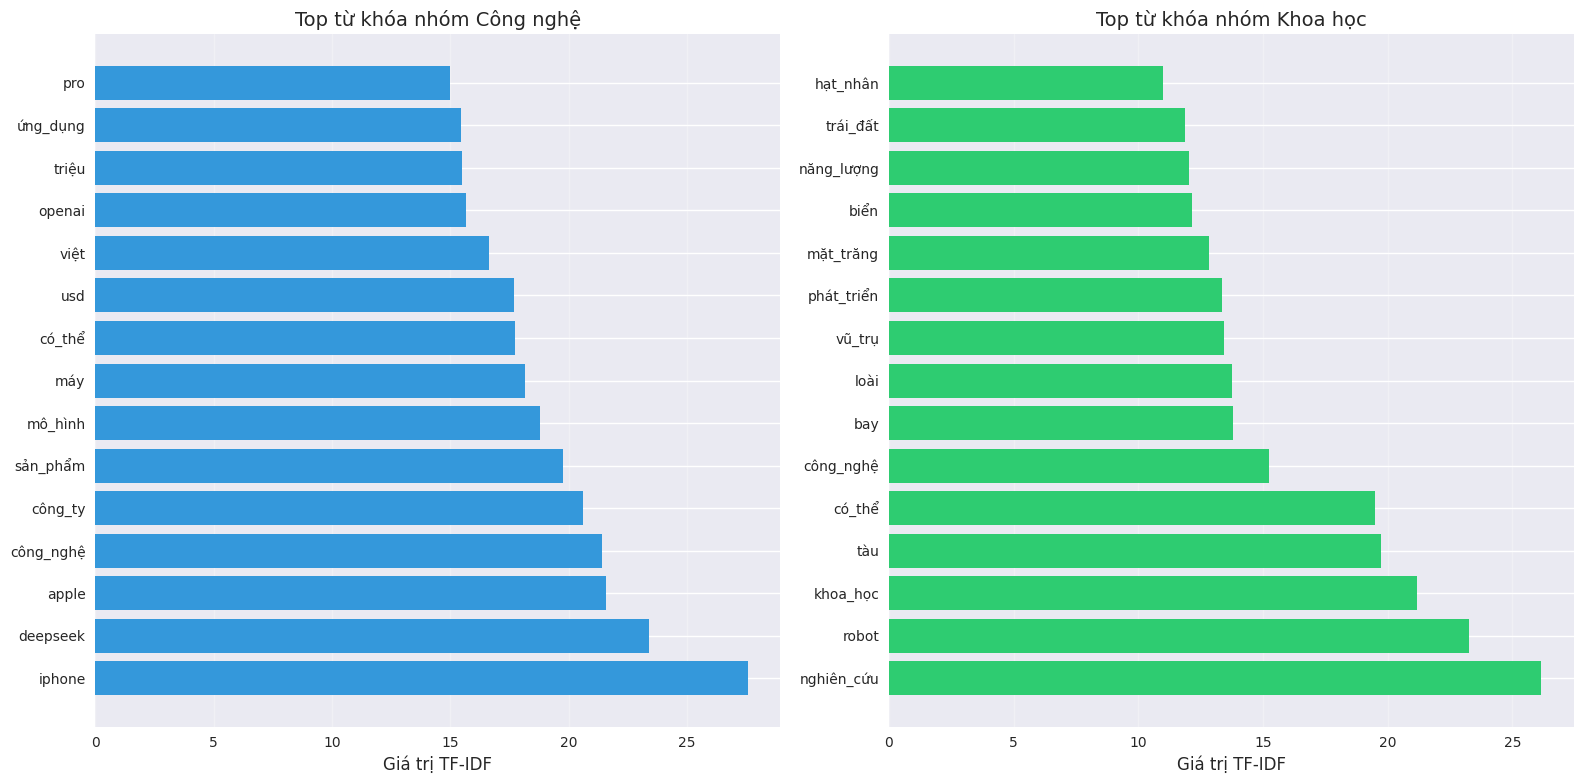

In [31]:
# Tách riêng các bài viết thuộc nhóm Khoa học và Công nghệ
tech_indices = df[df['group'] == 'Công nghệ'].index
science_indices = df[df['group'] == 'Khoa học'].index

# Trích xuất ma trận TF-IDF cho từng nhóm
tech_tfidf = tfidf_matrix[tech_indices]
science_tfidf = tfidf_matrix[science_indices]

# Lấy top từ khóa cho từng nhóm
tech_top_words = get_top_tfidf_words(tech_tfidf, feature_names, top_n=15)
science_top_words = get_top_tfidf_words(science_tfidf, feature_names, top_n=15)

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Biểu đồ cho Công nghệ
tech_words, tech_values = zip(*tech_top_words)
axes[0].barh(tech_words, tech_values, color='#3498db')
axes[0].set_title('Top từ khóa nhóm Công nghệ', fontsize=14)
axes[0].set_xlabel('Giá trị TF-IDF', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Biểu đồ cho Khoa học
science_words, science_values = zip(*science_top_words)
axes[1].barh(science_words, science_values, color='#2ecc71')
axes[1].set_title('Top từ khóa nhóm Khoa học', fontsize=14)
axes[1].set_xlabel('Giá trị TF-IDF', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 3.3. Mã hóa các biến danh mục

Ngoài dữ liệu văn bản, chúng ta cần mã hóa các biến danh mục khác như category, author, tags để có thể sử dụng trong mô hình phân loại.

### 3.3.1. Mã hóa category

Số lượng category khác nhau: 26


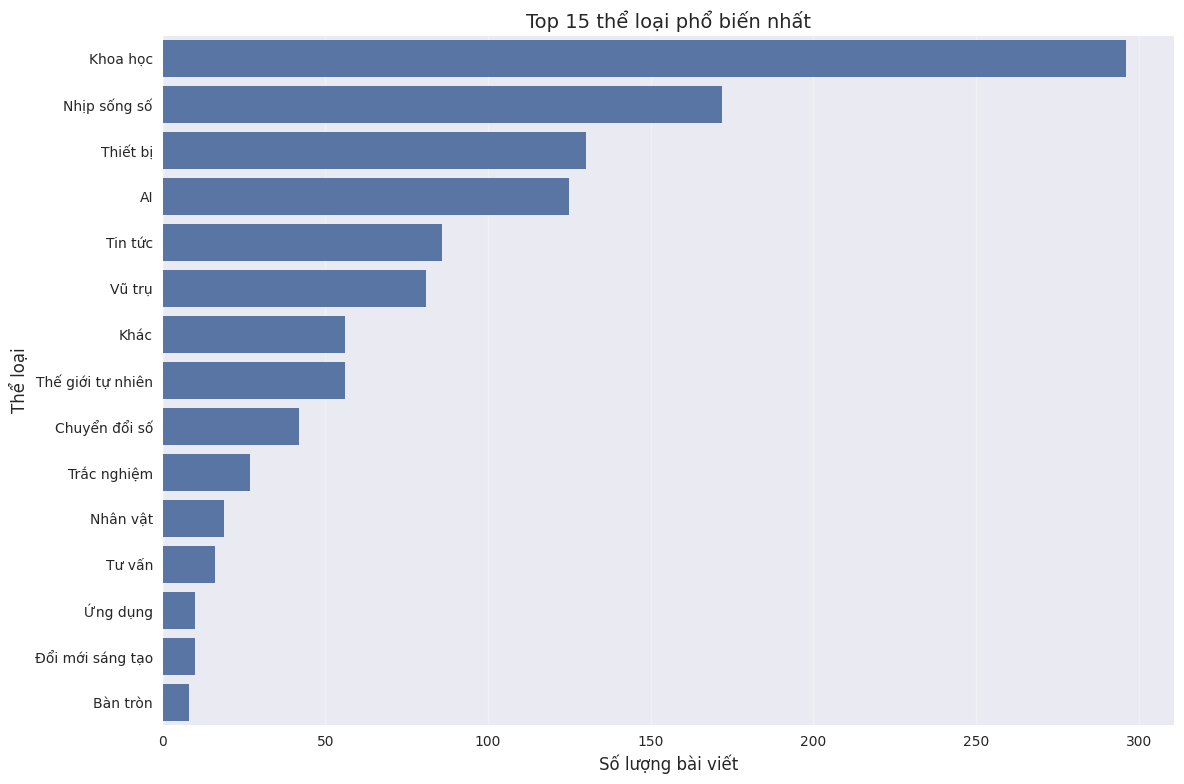

In [32]:
# Hiển thị phân bố category
top_categories = df['category'].value_counts().head(15)
print(f"Số lượng category khác nhau: {df['category'].nunique()}")

plt.figure(figsize=(12, 8))
sns.barplot(y=top_categories.index, x=top_categories.values)
plt.title('Top 15 thể loại phổ biến nhất', fontsize=14)
plt.xlabel('Số lượng bài viết', fontsize=12)
plt.ylabel('Thể loại', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# Mã hóa one-hot cho category
from sklearn.preprocessing import OneHotEncoder

# Lấy top 10 category phổ biến nhất, còn lại gom vào "Other"
top_10_categories = top_categories.index[:10]
df['category_cleaned'] = df['category'].apply(lambda x: x if x in top_10_categories else 'Other')

# One-hot encoding
category_encoder = OneHotEncoder(sparse_output=False)
category_encoded = category_encoder.fit_transform(df[['category_cleaned']])
category_columns = [f'category_{cat}' for cat in category_encoder.categories_[0]]

# Thêm vào DataFrame
category_df = pd.DataFrame(category_encoded, columns=category_columns)
df = pd.concat([df, category_df], axis=1)

print(f"Đã mã hóa category thành {len(category_columns)} cột")
print(f"Các cột category mới: {', '.join(category_columns[:5])}...")

Đã mã hóa category thành 11 cột
Các cột category mới: category_AI, category_Chuyển đổi số, category_Khoa học, category_Khác, category_Nhịp sống số...


### 3.3.2. Mã hóa tags

Tổng số tags duy nhất: 2149
Top 5 tags phổ biến nhất: [('ai', 167), ('mỹ', 104), ('trung quốc', 100), ('apple', 69), ('deepseek', 57)]


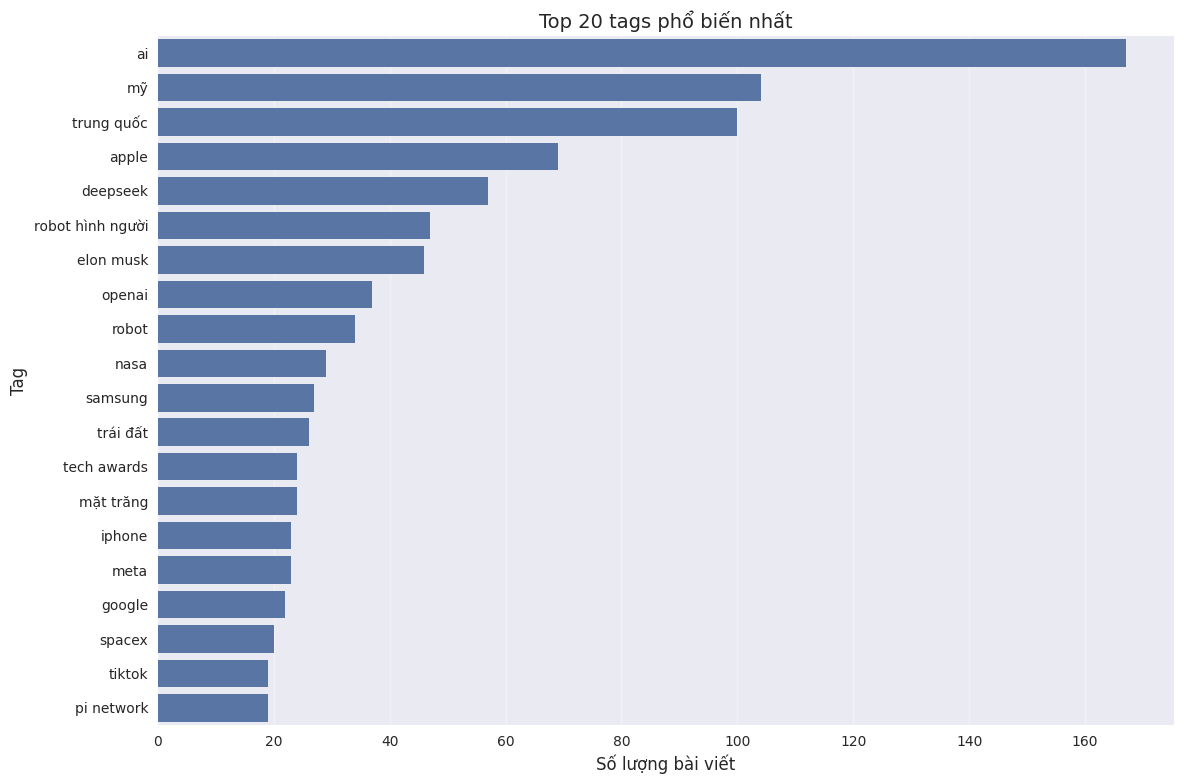

In [34]:
# Thống kê tags phổ biến
all_tags = [tag for tags_list in df['tags_list'] for tag in tags_list if isinstance(tags_list, list)]
tag_counter = Counter(all_tags)
top_tags = tag_counter.most_common(20)

print(f"Tổng số tags duy nhất: {len(tag_counter)}")
print(f"Top 5 tags phổ biến nhất: {top_tags[:5]}")

# Vẽ biểu đồ top tags
plt.figure(figsize=(12, 8))
tags, counts = zip(*top_tags)
sns.barplot(x=counts, y=tags)
plt.title('Top 20 tags phổ biến nhất', fontsize=14)
plt.xlabel('Số lượng bài viết', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# Lấy top 50 tags phổ biến nhất để mã hóa
top_50_tags = [tag for tag, _ in tag_counter.most_common(50)]

# Tạo biến đánh dấu cho mỗi tag phổ biến
for tag in top_50_tags:
    tag_col_name = f'tag_{tag.replace(" ", "_")}'
    df[tag_col_name] = df['tags_list'].apply(lambda x: 1 if tag in x else 0)

print(f"Đã mã hóa {len(top_50_tags)} tags phổ biến nhất")

# Hiển thị một số cột tag vừa tạo
tag_cols = [col for col in df.columns if col.startswith('tag_')]
print(f"Một số cột tag đã mã hóa: {', '.join(tag_cols[:5])}...")

Đã mã hóa 50 tags phổ biến nhất
Một số cột tag đã mã hóa: tag_ai, tag_mỹ, tag_trung_quốc, tag_apple, tag_deepseek...


## 3.4. Tổng hợp và lưu dữ liệu đã mã hóa

In [36]:
# Tạo DataFrame chứa các đặc trưng TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{word}' for word in feature_names])

# Chỉ giữ lại một số cột TF-IDF quan trọng để giảm kích thước dữ liệu
# Lấy top 100 từ có giá trị TF-IDF cao nhất
top_100_words = get_top_tfidf_words(tfidf_matrix, feature_names, top_n=100)
top_100_words_names = [word for word, _ in top_100_words]
tfidf_cols_to_keep = [f'tfidf_{word}' for word in top_100_words_names]

# Chọn cột
tfidf_df_reduced = tfidf_df[tfidf_cols_to_keep]

# Kết hợp với DataFrame gốc
df_encoded = pd.concat([df, tfidf_df_reduced], axis=1)

# Hiển thị thông tin DataFrame sau khi mã hóa
print(f"Kích thước dữ liệu sau khi mã hóa: {df_encoded.shape}")

# Lưu dữ liệu đã mã hóa
df_encoded.to_csv('../clean_data/vnexpress_encoded_data.csv', index=False, encoding='utf-8-sig')
print("Đã lưu dữ liệu đã mã hóa vào clean_data/vnexpress_encoded_data.csv")

Kích thước dữ liệu sau khi mã hóa: (1182, 200)
Đã lưu dữ liệu đã mã hóa vào clean_data/vnexpress_encoded_data.csv


## 3.5. Kết luận

Trong notebook này, chúng ta đã thực hiện các bước mã hóa dữ liệu quan trọng:

1. Tiền xử lý văn bản (loại bỏ stopwords, chuyển chữ thường)
2. Vector hóa văn bản sử dụng TF-IDF
3. Phân tích từ khóa quan trọng giữa các nhóm bài viết
4. Mã hóa các biến danh mục (category, tags)
5. Tổng hợp các đặc trưng đã mã hóa

Quá trình mã hóa đã chuyển đổi dữ liệu văn bản và danh mục thành dạng số mà các thuật toán máy học có thể sử dụng hiệu quả. Trong notebook tiếp theo, chúng ta sẽ tiếp tục với việc tạo đặc trưng (feature engineering) và phân tích đa biến để tìm hiểu sâu hơn về mối quan hệ giữa các biến.